There will be description stuff here when I know more what we are doing...

In [390]:
# fake figures dir
fake_figs_dir = '/Users/jnaiman/Downloads/tmp/fake_figs/'

# which to check?
dirs_latex = ['arxiv/9901', 'arxiv_new/2301', 'arxiv_new/2302']
base_dir_arxiv = '/Users/jnaiman/Dropbox/wwt_image_extraction/'

# savefiles
fullproc_r = '/Users/jnaiman/LMM_Figure_Parsing/resources/'

# get title and x/y labels from most frequent words
data_dir = '/Users/jnaiman/LMM_Figure_Parsing/resources/data/'

# save small bits of data?
save_smalls = True
save_small_dir = '/Users/jnaiman/LMM_Figure_Parsing/small_data/'
small_data_number = 10 # how many plots to make?
#small_data_number = 3 # how many plots to make?

In [435]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor
import json

import spacy

# this is hacktacular from: https://github.com/ReadingTimeMachine/TexSoup
# and needs to be updated
tex_lib = '/Users/jnaiman/TexSoup/'
from sys import path
path.append(tex_lib)
import TexSoup
from TexSoup import preprocessing, postprocess

from nltk.corpus import stopwords
import time

# from matplotlib import font_manager
# plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}' #for \text command

nlp = spacy.load("en_core_web_sm")

# written libs
from importlib import reload # debug
import synthetic_fig_utils # debug
reload(synthetic_fig_utils) # debug
from synthetic_fig_utils import subset_by_percent, get_line_styles, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks, get_titles_or_labels, \
 get_font_info
 #get_data, make_plot

use_uniques = True # use unique inlines
verbose = True

In [392]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')
#fonts_loc = dfont['font location'].values
font_names = dfont['font name'].values
#font_names

In [393]:
# for saving numpy arrays
# https://stackoverflow.com/questions/26646362/numpy-array-is-not-json-serializable
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return 'non serializable entry'
        return json.JSONEncoder.default(self, obj)

## Functions for image generation

In [394]:
# for linestyles
linestyles = get_line_styles()

# for plot styles
plot_styles = plt.style.available

# for markers
from matplotlib.lines import Line2D
marker_dir = Line2D.markers

markers = []
for m,mn in marker_dir.items():
    if type(m) == str:
        if 'None' not in m.lower() and 'nothing' not in mn.lower():
            #print(m, mn)
            markers.append(m)
    else:
        #print(m,mn)
        markers.append(m)

markers = np.array(markers,dtype=object)

# for colors
# how many random colors to generate?
# e.g. colors = colors_(6)
colors_ = lambda n: list(map(lambda i: "#" + "%06x" % np.random.randint(0, 0xFFFFFF),range(n)))

In [395]:
# all clean words
with open(data_dir+'words_cleaned.pickle','rb') as f:
    words_cleaned = pickle.load(f)

# also cleaned words
normalized=True
pdf_letters = []; ocr_letters = []; counts = []; counts_unnormed = []
for pl,ols in words_cleaned.items():
    if normalized:
        cdiv=0.0
        for ol,c in ols.items(): # % in OCR
            cdiv += c
    else:
        cdiv = 1.0
        
    for ol,c in ols.items():
        pdf_letters.append(pl)
        ocr_letters.append(ol)
        counts.append(c/cdiv*100)
        counts_unnormed.append(c)
        
df_words_clean = pd.DataFrame({'pdf_letters':pdf_letters,
                        'ocr_letters':ocr_letters,
                        'counts':counts, 'counts unnormalized':counts_unnormed})
# stop words
# lets look for stopwords
stop_words_all = stopwords.words('English')

# get upper case alpha characters
alphas = list(string.ascii_lowercase)
alphas_lower = alphas.copy()
# add larger ones
for a in alphas_lower:
    alphas.append(a.upper())

digits = np.arange(0,10,1).astype('int').astype('str').tolist()

punctuation = list(string.punctuation)
# pop out our markers
for p in ['^','@']:
    try:
        i = punctuation.index(p)
        punctuation.pop(i)
    except:
        pass
        
not_freq_words = []
not_freq_words.extend(stop_words_all)
not_freq_words.extend(digits)
not_freq_words.extend(alphas)
not_freq_words.extend(punctuation)

# other randoms to take out
words_randoms = []
words_randoms.extend(['-','fig','et'])

df_freq = df_words_clean.loc[~((df_words_clean['pdf_letters'].isin(not_freq_words)) & (df_words_clean['ocr_letters'].isin(not_freq_words)))]
df_freq_large = df_words_clean.loc[~(df_words_clean['pdf_letters'].isin(not_freq_words))]

# how many top words?
ntop = 1000
pdf_words = df_freq_large.sort_values('counts unnormalized',ascending=False).iloc[:ntop]['pdf_letters'].values

df_freq_top = df_words_clean.loc[(df_words_clean['pdf_letters'].isin(pdf_words))&(df_words_clean['ocr_letters'].isin(pdf_words))]
df_freq_top_large = df_words_clean.loc[df_words_clean['pdf_letters'].isin(pdf_words)]
df_freq_top_large = df_freq_top_large.loc[~df_freq_top_large['pdf_letters'].isin(words_randoms)]
print(len(df_freq_top),len(df_freq_top_large))

# cut off lower-counted things
tol_count = 5
df_freq_top = subset_by_percent(df_freq_top.copy(), tol_count = tol_count) # formatting
df_freq_top_large = subset_by_percent(df_freq_top_large.copy(), tol_count = tol_count) # formatting

words = " ".join(df_freq_top_large['pdf_letters'].unique().tolist())
doc = nlp(words)

popular_nouns = []
# loop and get just the nouns
for token in doc:
    if (str(token.pos_) == 'NOUN') and (token.text not in words_randoms):
        popular_nouns.append(token.text)

5505 173468
shape of output= (1112, 5)
shape of output= (17464, 5)


In [396]:
# get a random inline math formula
recreate_inlines = False # if true, you need access to data!

if recreate_inlines:
    inlines = []
    
    texfiles = glob(base_dir_arxiv + dirs_latex[0] + '/*/*.tex')
    for i in range(1,len(dirs_latex)):
        texfiles.extend(glob(base_dir_arxiv + dirs_latex[i] + '/*/*.tex'))
    #len(texfiles)

    for ii,f in enumerate(texfiles):
        if ii%100 == 0:
            print('on', ii+1, 'of', len(texfiles), 'so far have', len(inlines), 'inline formulas')
            
    # inline_math = ''
    # while inline_math == '':
        
        #f = np.random.choice(texfiles)
        try:
            with open(f, 'r') as ff:
                tex = ff.read()
        except Exception as e:
            if verbose:
                print('issue opening file:', f)
                print(e)
            continue
    
        try:
            soup = TexSoup.TexSoup(r''+tex, tolerance=0)
        except Exception as e:
            if verbose:
                print('issue makign soup for:', f)
                print(e)
            continue
            
        # pre-process with our TexSoup
        err = False
        tex_doc = preprocessing.process_begin_end(tex) # cleaning begin/end
        tex_doc, error_accents = preprocessing.clean_accents(tex_doc) # parse accents
        if error_accents:
            continue
        # get new commands/envs
        newcommands, newenvironments = preprocessing.get_newcommands_and_newenvs(tex_doc,
                                                                             verbose=False)
        args_newcommands,err = preprocessing.find_args_newcommands(newcommands,error_out=False, 
                                                               verbose=False)
        if err:
            continue 
        args_newenvironments, err = preprocessing.find_args_newenvironments(newenvironments,
                                                                   error_out=False, verbose=False)        
        if err:
            continue
    
          
        error = False
        try:
            comments, find_replace, error = preprocessing.generate_find_replace_newcommands(args_newcommands, 
                                                                   verbose=False,arg_type = 'newcommand')  
            error = error[0]
        except:
            error = True
            
        if error:
            continue
        
        warnings = []
        try:
            tex_doc_nc, error, warnings = preprocessing.replace_newcommands_and_newenvironments(tex_doc, 
                                                                                  args_newcommands,
                                                                                  args_newenvironments,
                                                                                                verbose=True)
        except:
            error = [True]
            
        if error[0]:
            continue
            
        # try to make soup
        error = False
        try:
            soup = TexSoup.TexSoup(r''+tex_doc_nc, tolerance=0)
        except:
            error = True
        if error:
            continue
    
        # clean up commands with slashes
        error = False
        try:
            soup_clean = postprocess.clean_slash_commands(soup)
        except:
            error = True
        if error:
            continue
            
        error = False
        try:
            texout_arr = postprocess.parse_soup_to_tags(soup,tex_doc_nc, verbose=False)
        except:
            error = True
        if error:
            continue

        for t,tt in texout_arr:
            if tt == 'inline':
                inlines.append(t)
        #inlines = np.unique(inlines).tolist()

    #inlines = np.unique(inlines).tolist()
    with open(fullproc_r + 'inlines.csv','w') as f:
        for l in inlines:
            print(l.replace('\n', ' '),file=f)
    # and uniques
    inlines_u = np.unique(inlines)
    with open(fullproc_r + 'inlines_unique.csv','w') as f:
        for l in inlines_u:
            print(l.replace('\n', ' '),file=f)

    inlines_ignore = []
    for il,l in enumerate(inlines):
        try:
            plt.close('all')
            plt.plot([1,2],[1,2])
            plt.xlabel(r""+l)
            plt.savefig(fake_figs_dir + 'p1.png')
        except Exception as e:
            #print(e)
            inlines_ignore.append(il)

    with open(fullproc_r + 'inlines_uniques_ignore.csv','w') as f:
        for l in inlines_ignore:
            print(l,file=f)
else:
    if not use_uniques:
        print('not using unique inlines, not sure if this is a good idea!')
        with open(fullproc_r + 'inlines.csv', 'r') as f:
            inlines = f.readlines()
    else:
        with open(fullproc_r + 'inlines_unique.csv', 'r') as f:
            inlines = f.readlines()
        with open(fullproc_r + 'inlines_uniques_ignore.csv', 'r') as f:
            inds_ignore = f.readlines()
        inds_ignore = np.array(inds_ignore).astype('int')
        inlines = np.delete(inlines, inds_ignore)
        

print('number of inlines = ', len(inlines))

number of inlines =  33201


In [397]:
# xmin=0
# xmax=1
# ymin=2
# ymax=3
# npoints = 10


# #np.random.uniform(low=np.array([xmin,ymin]),high=np.array([xmax,ymax]), size=np.array(size))
# #np.random.uniform(low=xy_min, high=xy_max, size=(n,2))

# np.random.uniform(low=np.array([xmin,ymin]),high=np.array([xmax,ymax]), size=[npoints,2])


In [398]:
#np.random.uniform(0,1,size=(npoints,npoints))

In [399]:
def get_random(xmin,xmax,ymin=0,ymax=0, zmin=0,zmax=1,hmin=0,hmax=1,
               ndims=1,
               npoints=10,grid=False,
              function=np.random.uniform):
    """
    Generic random distribution
    ndims : 1-3, how many dimensions for the data
    xmin/xmax : ranges for dimension 1
    ymin/ymax : ranges for dimension 2
    zmin/zmax : ranges for dimension 3
    hmin/hmax : ranges for dimension 3, grid=True (3d "heatmap")
    npoints : number of random points (can be a tuple for different values)
    function : how to generate the random numbers
    grid : if ndim>1 and grid is set to True instead of individual points, 
           you will get a data on a uniform grid
    """
    if ndims == 1:
        #print(xmin)
        #print(xmax)
        #print(npoints)
        return function(low=xmin, high=xmax, size=npoints)
    elif ndims == 2:
        if not grid:
            return function(low=np.array([xmin,ymin]),
                            high=np.array([xmax,ymax]), size=[npoints,2])
        else:
            x = np.linspace(xmin,xmax,npoints[0])
            y = np.linspace(ymin,ymax,npoints[1])
            #grid = function(low=zmin,high=zmax,size=(npoints,npoints))
            grid = function(low=zmin,high=zmax,size=npoints) # npoints is a tuple (nx,ny)
            return {'x':x, 'y':y, 'z':grid.T} # .T for right shape
    elif ndims == 3:
        if not grid:
            return function(low=np.array([xmin,ymin,zmin]),
                            high=np.array([xmax,ymax,zmax]), size=[npoints,3])
        else:
            x = np.linspace(xmin,xmax,npoints[0])
            y = np.linspace(ymin,ymax,npoints[1])
            z = np.linspace(zmin,zmax,npoints[2])
            #grid = function(low=hmin,high=hmax,size=(npoints,npoints,npoints))
            grid = function(low=hmin,high=hmax,size=npoints) # tuple (nx,ny,nz)
            return {'x':x, 'y':y, 'z':z, 'h':grid.T} # .T for right shape

    else:
        print('ndims=', ndims, 'not supported for "get_random" function!')
        import sys; sys.exit()
        


##### SPECIFIC DISTRIBUTIONS #######
def get_random_data(plot_type,xmin,xmax,ymin=0,ymax=1,zmin=0,zmax=0,
                    prob_same_x=0.5, nlines=1, npoints=1,
                   cmin=0, cmax=1):
    """
    npoints : can be tuple if multi dimension
    """
    # do we have all the same x for all points?
    if plot_type == 'line':
        p = np.random.uniform(0,1)
        xs = []
        if p <= prob_same_x: # same x
            #x = np.random.random(npoints)*(xmax-xmin) + xmin
            x = get_random(xmin,xmax,ndims=1,npoints=npoints)
            x = np.sort(x)
            # repeat for all
            for i in range(nlines):
                xs.append(x)
        else: # different
            for i in range(nlines):
                #x = np.random.random(npoints)*(xmax-xmin) + xmin
                # print('xmin:', xmin)
                # print('xmax:', xmax)
                x = get_random(xmin,xmax,ndims=1,npoints=npoints)
                x = np.sort(x)
                xs.append(x)
            
        ys = []
        for i in range(nlines):
            #print('ymin,ymax before:', ymin, ymax)
            #ys.append( np.random.random(npoints)*(ymax[i]-ymin[i]) + ymin[i] )
            y = get_random(ymin[i],ymax[i],ndims=1,npoints=npoints)
            #print(y)
            ys.append(y)
        return xs,ys
    elif plot_type == 'scatter':
        # xs = np.random.uniform(low=xmin, high=xmax, size=npoints)
        # ys = np.random.uniform(low=ymin, high=ymax, size=npoints)
        # colors = np.random.uniform(low=cmin,
        #                            high=cmax,
        #                           size=npoints)
        xs = get_random(xmin,xmax,ndims=1,npoints=npoints)
        ys = get_random(ymin,ymax,ndims=1,npoints=npoints)
        colors = get_random(cmin,cmax,ndims=1,npoints=npoints)
        # print('len xs:', len(xs))
        # print('len ys:', len(ys))
        # print('len colors:', len(colors))
        return xs,ys,colors
    elif plot_type == 'histogram':
        x = get_random(xmin,xmax,ndims=1,npoints=npoints)
        return x
    elif plot_type == 'contour':
        #xs = get_random(xmin,xmax,ndims=1,npoints=npoints)
        #ys = get_random(ymin,ymax,ndims=1,npoints=npoints)
        #colors = get_random(cmin,cmax,ndims=1,npoints=npoints)
        data = get_random(xmin,xmax,ymin=ymin,ymax=ymax, ndims=2, grid=True, 
                         npoints=npoints, zmin=zmin,zmax=zmax) # {'x':x, 'y':y, 'z':grid}
        xs = data['x']; ys = data['y']
        colors = data['z']
        return xs,ys,colors


In [400]:
# CONTOUR DATA
def get_contour_data(plot_params, distribution = 'random',
                     verbose=True):
    """
    plot_params : directory with plot params
    """

    nx = int(round(np.random.uniform(low=plot_params['npoints']['nx']['min'], 
                                          high=plot_params['npoints']['nx']['max'])))
    ny = int(round(np.random.uniform(low=plot_params['npoints']['ny']['min'], 
                                          high=plot_params['npoints']['ny']['max'])))
    
    xmin,xmax = plot_params['xmin'],plot_params['xmax']
    ymin,ymax = plot_params['ymin'],plot_params['ymax']

    x1 = np.random.uniform(low=xmin, high=xmax)
    x2 = np.random.uniform(low=xmin, high=xmax)
    if x1<x2:
        xmin = x1; xmax = x2
    else:
        xmin=x2; xmax=x1
    y1 = np.random.uniform(low=ymin, high=ymax)
    y2 = np.random.uniform(low=ymin, high=ymax)
    if y1<y2:
        ymin = y1; ymax = y2
    else:
        ymin=y2; ymax=y1
    c1 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    c2 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    if c1<c2:
        cmin = c1; cmax = c2
    else:
        cmin=c2; cmax=c1

    if distribution == 'random':
        #print(xmin,xmax)
        xs,ys,colors = get_random_data('contour',xmin,xmax,ymin,ymax,
                                  npoints=(nx,ny),
                                  zmin=cmin, zmax=cmax) 

    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    xerr,yerr = [],[] # x/y error maybe later

    # if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
    #     hasXErr = True
    #     scale = xmax-xmin
    #     xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min']*scale, 
    #                              high=plot_params['error bars']['x']['size']['max']*scale,
    #                              size=npoints)
    # if np.random.uniform(0,1) <= plot_params['error bars']['y']['prob']: # yes
    #     hasYErr = True
    #     scale = ymax-ymin
    #     yerr = np.random.uniform(low=plot_params['error bars']['y']['size']['min']*scale, 
    #                              high=plot_params['error bars']['y']['size']['max']*scale,
    #                              size=npoints)

    #print(xerr)
    #print(yerr)
    return xs, ys, colors, xerr, yerr

In [401]:
# LINES & SCATTERS: DATA
def get_line_data(plot_params, npoints,nlines,xmin=0, xmax=1, ymin=0, ymax=1, 
                  prob_same_x=0.1,
                  xordered=True, verbose=True,
                 pick_xrange=True, pick_yrange=True,
                 distribution='random'):
    """
    ymin/ymax : can be a number of a list, if list, needs to be matched up with number of nlines
    xordered : do we want to put the x-points in a monotonic order?
    """
    if (type(ymin) not in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray]):
        pass
    elif ((type(ymin) not in [list, np.ndarray]) and (type(ymax) in [list, np.ndarray])):
        if verbose: print('type of ymin and ymax must be the same!  Will fall back on ints')
        ymax = ymax[0]
    elif ((type(ymin) in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray])):
        if verbose: print('type of ymin and ymax must be the same!  Will fall back on ints')
        ymin = ymin[0]
    elif len(ymin) != nlines or len(ymax) != nlines:
        if verbose: print('length of ymax, ymin not the same as "nlines", falling back on ints')
        ymin = ymin[0]; ymax = ymax[0]


    # print('xmin get_line_data:', xmin)
    # print('xmax get_line_data:', xmax)
    nlines = int(round(np.random.uniform(low=nlines['min'], high=nlines['max'])))
    npoints = int(round(np.random.uniform(low=npoints['min'], high=npoints['max'])))

    # pick randomly
    if pick_xrange:
        x1 = np.random.uniform(low=xmin, high=xmax)
        x2 = np.random.uniform(low=xmin, high=xmax)
        if x1<x2:
            xmin = x1; xmax = x2
        else:
            xmin=x2; xmax=x1
    if pick_yrange:
        y1 = np.random.uniform(low=ymin, high=ymax)
        y2 = np.random.uniform(low=ymin, high=ymax)
        if y1<y2:
            ymin = y1; ymax = y2
        else:
            ymin=y2; ymax=y1
    # print('xmin get_line_data 2:', xmin)
    # print('xmax get_line_data 2:', xmax)

    # into arrays
    if (type(ymin) not in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray]):
        ymin = np.repeat(ymin,nlines)
        ymax = np.repeat(ymax,nlines)

    if distribution == 'random':
        xs,ys = get_random_data('line',xmin,xmax,ymin,ymax,
                    prob_same_x=prob_same_x, 
                            nlines=nlines, npoints=npoints)

    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    xerrs,yerrs = [],[]

    # for error rate
    #scale = 
    if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
        hasXErr = True
        scale = np.max(xmax)-np.min(xmin)
        for i in range(nlines):
            xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min']*scale, 
                                 high=plot_params['error bars']['x']['size']['max']*scale,
                                 size=npoints)
            xerrs.append(xerr)
    if np.random.uniform(0,1) <= plot_params['error bars']['y']['prob']: # yes
        hasYErr = True
        scale = np.max(ymax)-np.min(ymin)
        for i in range(nlines):
            yerr = np.random.uniform(low=plot_params['error bars']['y']['size']['min']*scale, 
                                 high=plot_params['error bars']['y']['size']['max']*scale,
                                 size=npoints)
            yerrs.append(yerr)
    
    return xs, ys, xerrs, yerrs

In [402]:
def get_scatter_data(plot_params, distribution = 'random',
                     verbose=True):
    """
    plot_params : directory with plot params
    """

    npoints = int(round(np.random.uniform(low=plot_params['npoints']['min'], 
                                          high=plot_params['npoints']['max'])))
    
    xmin,xmax = plot_params['xmin'],plot_params['xmax']
    ymin,ymax = plot_params['ymin'],plot_params['ymax']


    x1 = np.random.uniform(low=xmin, high=xmax)
    x2 = np.random.uniform(low=xmin, high=xmax)
    if x1<x2:
        xmin = x1; xmax = x2
    else:
        xmin=x2; xmax=x1
    y1 = np.random.uniform(low=ymin, high=ymax)
    y2 = np.random.uniform(low=ymin, high=ymax)
    if y1<y2:
        ymin = y1; ymax = y2
    else:
        ymin=y2; ymax=y1
    c1 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    c2 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    if c1<c2:
        cmin = c1; cmax = c2
    else:
        cmin=c2; cmax=c1

    if distribution == 'random':
        xs,ys,colors = get_random_data('scatter',xmin,xmax,ymin,ymax,
                                  npoints=npoints,
                                  cmin=cmin, cmax=cmax)

    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    xerr,yerr = [],[]

    if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
        hasXErr = True
        scale = xmax-xmin
        xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min']*scale, 
                                 high=plot_params['error bars']['x']['size']['max']*scale,
                                 size=npoints)
    if np.random.uniform(0,1) <= plot_params['error bars']['y']['prob']: # yes
        hasYErr = True
        scale = ymax-ymin
        yerr = np.random.uniform(low=plot_params['error bars']['y']['size']['min']*scale, 
                                 high=plot_params['error bars']['y']['size']['max']*scale,
                                 size=npoints)

    #print(xerr)
    #print(yerr)
    return xs, ys, colors, xerr, yerr

In [403]:
# HISTOGRAM PLOTS: PLOT
def get_histogram_data(plot_params, distribution = 'random',
                     verbose=True):
    """
    plot_params : plot parameters
    """

    npoints = int(round(np.random.uniform(low=plot_params['npoints']['min'], 
                                          high=plot_params['npoints']['max'])))
    
    xmin,xmax = plot_params['xmin'],plot_params['xmax']

    x1 = np.random.uniform(low=xmin, high=xmax)
    x2 = np.random.uniform(low=xmin, high=xmax)
    if x1<x2:
        xmin = x1; xmax = x2
    else:
        xmin=x2; xmax=x1

    ys = []
    if distribution == 'random':
        xs = get_random_data('histogram',xmin,xmax,
                                  npoints=npoints)
    
    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    # xerr,yerr = [],[]

    if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
        hasXErr = True
    #     #scale = xmax-xmin
    #     scale = xs
    #     xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min'], 
    #                              high=plot_params['error bars']['x']['size']['max'],
    #                              size=npoints)*scale
        
    if np.random.uniform(0,1) < plot_params['horizontal prob']: # probability that we have a horizontal bar plot
        # flip
        ys = xs.copy()
        #yerr = xerr.copy()
        #xs = []; ys = []
        hasYErr = True
        hasXErr = False

    return xs, ys, hasXErr, hasYErr # this is different than other plots!

In [404]:
# LINES PLOT
def get_line_plot(plot_params, data, ax):
    datas = []
    linestyles_here = []; linethicks_here = []; markers_here = []
    marker_sizes_here = []
    xerrs = []; yerrs = []
    hasMarker = False
    p = np.random.uniform(0,1)
    if p <= plot_params['markers']['prob']:
        hasMarker = True

    elinewidth = int(round(np.random.uniform(low=plot_params['error bars']['elinewidth']['min'], 
                                            high=plot_params['error bars']['elinewidth']['max'])))
    # draw lines
    xerrs = []; yerrs = []
    for i in range(len(data['ys'])):
        marker = np.random.choice(markers)
        lthick = np.random.uniform(low=plot_params['line thick']['min'], 
                                   high=plot_params['line thick']['max'])

        # choose random linestyle
        linestyle = np.random.choice(linestyles)
        if hasMarker:
            marker_size = int(round(np.random.uniform(low=plot_params['markers']['size']['min'],
                                            high=plot_params['markers']['size']['min'])))
            data_here, = ax.plot(data['xs'][i],data['ys'][i], linewidth=lthick, 
                                 linestyle = linestyle, marker=marker,
                                markersize=marker_size)
        else:
            data_here, = ax.plot(data['xs'][i],data['ys'][i], linewidth=lthick, 
                                 linestyle = linestyle)
            marker = ''
            marker_size = -1

        cols = []
        plt.draw()
        try:
            cols.append(ImageColor.getcolor(data_here.get_color(), "RGBA"))
        except:
            cols.append( (0,0,0) ) # I assume
        cols = np.array(cols)/255.

        if 'xerrs' in data:# and 'yerrs' not in data: # have x-errors
            (_, caps, bars) = ax.errorbar(data['xs'][i],data['ys'][i],xerr=data['xerrs'][i],
                                         linewidth=0,elinewidth=elinewidth,
                                         markersize=0, ecolor=cols, zorder=0)
            xerrs.append(bars)
        if 'yerrs' in data:# and 'xerrs' not in data: # have x-errors
            (_, caps, bars) = ax.errorbar(data['xs'][i],data['ys'][i],yerr=data['yerrs'][i],
                                         linewidth=0, elinewidth=elinewidth,
                                         markersize=0, ecolor=cols, zorder=0)
            yerrs.append(bars)
        
        linethicks_here.append(lthick)
        linestyles_here.append(linestyle)
        markers_here.append(marker)
        datas.append(data_here)
        marker_sizes_here.append(marker_size)

    data_out = {'data':datas, 'plot params':{'linethick':linethicks_here, 
                                            'linestyles':linestyles_here,
                                            'markers':markers_here,
                                            'marker size':marker_sizes_here}
               }
    # add in x/y errors, if present
    if 'xerrs' in data:
        data_out['x error bars'] = xerrs
    if 'yerrs' in data:
        data_out['y error bars'] = yerrs
    return data_out, ax


In [185]:
# SCATTERS: PLOTS
def get_scatter_plot(plot_params, data, ax):
    p = np.random.uniform(0,1)
    cax = []; side = ''
    marker = np.random.choice(markers)
    marker_size = int(round(np.random.uniform(low=plot_params['markers']['size']['min'],
                                    high=plot_params['markers']['size']['min'])))
    if not p <= plot_params['colormap scatter']['prob']: # not have color map
        data_here = ax.scatter(data['xs'],data['ys'],marker=marker, s=marker_size) 
    else:
        data_here = ax.scatter(data['xs'],data['ys'], 
                               c=data['colors'],marker=marker, 
                              s=marker_size) # need to add color
        divider = make_axes_locatable(ax)

        # get probs
        probs = []; choices = []
        for k,v in plot_params['color bar']['location probs'].items():
            probs.append(v); choices.append(k)
        side = np.random.choice(choices, p=probs)
        size = np.random.uniform(low=plot_params['color bar']['size percent']['min'], 
                     high=plot_params['color bar']['size percent']['max'])
        size = str(int(round(size*100)))+'%'

        pad = np.random.uniform(low=plot_params['color bar']['pad']['min'], 
                                 high=plot_params['color bar']['pad']['max'])

        cax = divider.append_axes(side, size=size, pad=pad)
        # the side of the axis
        if side == 'right': # this maybe should become a random selection?
            axis_side = 'right'
            cax.yaxis.set_ticks_position(axis_side)
        elif side == 'left':
            axis_side = 'left'
            cax.yaxis.set_ticks_position(axis_side)
        elif side == 'top':
            axis_side = 'top'
            cax.xaxis.set_ticks_position(axis_side)
        elif side == 'bottom':
            axis_side = 'bottom'
            cax.xaxis.set_ticks_position(axis_side)

    xerrs = []; yerrs = []
    plt.draw()
    cols = data_here.get_facecolors()
    elinewidth = int(round(np.random.uniform(low=plot_params['error bars']['elinewidth']['min'], 
                                                 high=plot_params['error bars']['elinewidth']['max'])))
    if 'xerrs' in data:# and 'yerrs' not in data: # have x-errors
        (_, caps, bars) = ax.errorbar(data['xs'],data['ys'],xerr=data['xerrs'],
                                     linewidth=0,elinewidth=elinewidth,
                                     markersize=0, ecolor=cols, zorder=0)
        xerrs.append(bars)
    if 'yerrs' in data:# and 'xerrs' not in data: # have x-errors
        (_, caps, bars) = ax.errorbar(data['xs'],data['ys'],yerr=data['yerrs'],
                                     linewidth=0, elinewidth=elinewidth,
                                     markersize=0, ecolor=cols, zorder=0)
        yerrs.append(bars)
        
    # save data
    if cax != []:
        data_out = {'data':data_here, 'color bar':cax, 
                    'color bar params':{'side':side, 'pad':pad, 'size':size, 
                                       'axis side':axis_side, 
                                       'marker':marker, 'marker size':marker_size}
                   }
    else:
        data_out = {'data':data_here}

    # add in x/y errors, if present
    if 'xerrs' in data:
        data_out['x error bars'] = xerrs
    if 'yerrs' in data:
        #print("YESS TO Y IN DATA")
        data_out['y error bars'] = yerrs
    if 'xerrs' in data or 'yerrs' in data:
        data_out['error bar params']:{'elinewidth':elinewidth}
    
    return data_out, ax


In [186]:
#plt.imshow?

In [187]:
#plot_types_params['contour']

In [436]:
def get_contour_plot(plot_params, data, ax):
    p = np.random.uniform(0,1) # probability that has a colorbar
    #pi = np.random.uniform(0,1) # probability that is an image (vs a contour with lines)
    choices = []; probs = []
    for k,v in plot_params['image or contour']['prob'].items():
        choices.append(k)
        probs.append(v)
    plot_type = np.random.choice(choices, p=probs)
    cax = []; side = ''
    
    if plot_type == 'contour':
        nlevels = int(round(np.random.uniform(low=plot_params['nlines']['min'],
                                              high=plot_params['nlines']['max'])))
        data_here2 = ax.contour(data['xs'], data['ys'], data['colors'], nlevels)
        data_here = {'contour':data_here2}
    elif plot_type == 'image':
        real_x = data['xs']
        real_y = data['ys']
        dx = (real_x[1]-real_x[0])/2.
        dy = (real_y[1]-real_y[0])/2.
        extent = [real_x[0]-dx, real_x[-1]+dx, real_y[0]-dy, real_y[-1]+dy]
        #plt.imshow(data, extent=extent)
        data_here1 = ax.imshow(data['colors'], extent=extent)
        data_here = {'image':data_here1}
    elif plot_type == 'both':
        pg = np.random.uniform(0,1)
        grayContours = False
        if pg <= plot_params['image or contour']['both contours']['prob gray']: # probability that contours are gray for "both" situation
            grayContours = True
        cmap = np.random.choice(['gray', 'gray_r'])
        real_x = data['xs']
        real_y = data['ys']
        dx = (real_x[1]-real_x[0])/2.
        dy = (real_y[1]-real_y[0])/2.
        extent = [real_x[0]-dx, real_x[-1]+dx, real_y[0]-dy, real_y[-1]+dy]
        data_here1 = ax.imshow(data['colors'], extent=extent)
        nlevels = int(round(np.random.uniform(low=plot_params['nlines']['min'],
                                              high=plot_params['nlines']['max'])))
        if not grayContours:
            data_here2 = ax.contour(data['xs'], data['ys'], data['colors'], nlevels)
        else:
            data_here2 = ax.contour(data['xs'], data['ys'], data['colors'], nlevels,
                                   cmap=cmap)

        data_here = {'image':data_here1, 'contour':data_here2}
    else:
        print('not supported plot type!')
        import sys; sys.exit()

    if not p <= plot_params['colormap contour']['prob']: # not have color map
        pass 
    else:
        divider = make_axes_locatable(ax)

        # get probs
        probs = []; choices = []
        for k,v in plot_params['color bar']['location probs'].items():
            probs.append(v); choices.append(k)
        side = np.random.choice(choices, p=probs)
        size = np.random.uniform(low=plot_params['color bar']['size percent']['min'], 
                     high=plot_params['color bar']['size percent']['max'])
        size = str(int(round(size*100)))+'%'

        pad = np.random.uniform(low=plot_params['color bar']['pad']['min'], 
                                 high=plot_params['color bar']['pad']['max'])

        cax = divider.append_axes(side, size=size, pad=pad)
        # the side of the axis
        if side == 'right': # this maybe should become a random selection?
            axis_side = 'right'
            cax.yaxis.set_ticks_position(axis_side)
        elif side == 'left':
            axis_side = 'left'
            cax.yaxis.set_ticks_position(axis_side)
        elif side == 'top':
            axis_side = 'top'
            cax.xaxis.set_ticks_position(axis_side)
        elif side == 'bottom':
            axis_side = 'bottom'
            cax.xaxis.set_ticks_position(axis_side)
    plt.draw()

    # xerrs = []; yerrs = []
    # plt.draw()
    # cols = data_here.get_facecolors()
    # elinewidth = int(round(np.random.uniform(low=plot_params['error bars']['elinewidth']['min'], 
    #                                              high=plot_params['error bars']['elinewidth']['max'])))
    # if 'xerrs' in data:# and 'yerrs' not in data: # have x-errors
    #     (_, caps, bars) = ax.errorbar(data['xs'],data['ys'],xerr=data['xerrs'],
    #                                  linewidth=0,elinewidth=elinewidth,
    #                                  markersize=0, ecolor=cols, zorder=0)
    #     xerrs.append(bars)
    # if 'yerrs' in data:# and 'xerrs' not in data: # have x-errors
    #     (_, caps, bars) = ax.errorbar(data['xs'],data['ys'],yerr=data['yerrs'],
    #                                  linewidth=0, elinewidth=elinewidth,
    #                                  markersize=0, ecolor=cols, zorder=0)
    #     yerrs.append(bars)
        
    # save data
    if cax != []:
        data_out = {'data':data_here, 'color bar':cax, 
                    'color bar params':{'side':side, 'pad':pad, 'size':size, 
                                       'axis side':axis_side}#, 
                                       #'marker':marker, 'marker size':marker_size}
                   }
    else:
        data_out = {'data':data_here}

    # add in x/y errors, if present
    if 'xerrs' in data:
        data_out['x error bars'] = xerrs
    if 'yerrs' in data:
        #print("YESS TO Y IN DATA")
        data_out['y error bars'] = yerrs
    if 'xerrs' in data or 'yerrs' in data:
        data_out['error bar params']:{'elinewidth':elinewidth}
    
    return data_out, ax


In [437]:
# HISTOGRAMS: PLOTS
def get_histogram_plot(plot_params, data, ax):
    datas = []
    linestyles_here = []; linethicks_here = []; markers_here = []
    marker_sizes_here = []
    xerrs = []; yerrs = []

    elinewidth = int(round(np.random.uniform(low=plot_params['error bars']['elinewidth']['min'], 
                                            high=plot_params['error bars']['elinewidth']['max'])))
    rwidth = np.random.uniform(low=plot_params['rwidth']['min'], 
                                            high=plot_params['rwidth']['max'])
    #print('rwidth', rwidth)

    orientation='vertical' # default
    axis = 'xs'
    err = 'xerrs'
    if len(data['xs']) == 0: # flipped!
        axis = 'ys'
        err = 'yerrs'
        orientation='horizontal'


    # line boarder?
    lthick = int(round(np.random.uniform(low=plot_params['line thick']['min'], 
                               high=plot_params['line thick']['max'])))
    if np.random.uniform(0,1) > plot_params['line thick']['prob']:
        lthick = 0

    # choose random linestyle
    linestyle = np.random.choice(linestyles)

    # choose random color
    linecolor = np.array(ImageColor.getcolor(colors_(1)[0],'RGBA'))/255
    barcolor = np.array(ImageColor.getcolor(colors_(1)[0], 'RGBA'))/255

    # number of bins?
    nbins = int(round(np.random.uniform(low=plot_params['nbins']['min'], 
                                            high=plot_params['nbins']['max'])))

    if lthick > 0:
        data_here = ax.hist(data[axis], orientation=orientation, linewidth=lthick, 
                                     linestyle = linestyle, edgecolor=linecolor, 
                            color=barcolor, rwidth=rwidth, bins=nbins)
    else:
        data_here = ax.hist(data[axis], orientation=orientation, 
                                     linestyle = linestyle, edgecolor=linecolor, 
                            color=barcolor, rwidth=rwidth, bins=nbins)

    # add in error bars
    data_heights = data_here[0] # heights of DATA values
    bin_edges = data_here[1] # bin edges of DATA values
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    errs = []
    for b in data_heights:
        es = np.random.uniform(low=plot_params['error bars']['x']['size']['min'], 
                                        high=plot_params['error bars']['x']['size']['max'])
        errs.append(b*es)

    hasErr = False
    if 'xerrs' in data: # different!
        if data['xerrs']:
            hasErr = True
    elif 'yerrs' in data:
        if data['yerrs']:
            hasErr = True

    if hasErr:
        (_, caps, bars) = ax.errorbar(bin_centers,data_heights,yerr=errs,
                                          linewidth=0,elinewidth=elinewidth,
                                          markersize=0, ecolor=linecolor, zorder=10) # error bars on top
    
    xerr_bars = []; yerr_bars = []
    if 'xerrs' in data:
        #if len(data['xerrs']) > 0:
        if data['xerrs']: # DIFFERENT
            #print("YES XERR")
            xerr_bars = bars
    elif 'yerrs' in data:
        #if len(data['yerrs']) > 0:
        if data['yerrs']: # DIFFERENT
            #print("YES YERR")
            yerr_bars = bars

    data_out = {'data':data_here, 'plot params':{
                                            'linethick':lthick, 
                                            'linestyles':linestyle,
                                             'bar color':barcolor,
                                             'edge color':linecolor,
                                             'orientation':orientation,
                                             'rwidth':rwidth,
                                             'nbins':nbins
                                            }
               }
    
    # add in x/y errors, if present
    if len(xerr_bars) > 0:
        data_out['x error bars'] = [xerr_bars] # list for formatting
        data_out['plot params']['elinewidth'] = elinewidth
    if len(yerr_bars) > 0:
        data_out['y error bars'] = [yerr_bars]
        data_out['plot params']['elinewidth'] = elinewidth
    return data_out, ax

In [194]:
# CONTOUR PLOTS


In [195]:
#data = get_data(plot_types_params['line'], plot_type='line')

In [410]:
##### GENERIC DATA AND PLOTS #####
def get_data(plot_params, plot_type='line', #npoints = 100, xmin=0, xmax=1, ymin=0, ymax=1, 
             #xordered=True, nlines=1, # line params
             verbose=True, xordered=True # general params
            ):
    if plot_type == 'line':
        xs, ys, xerrs,yerrs = get_line_data(plot_params, plot_params['npoints'], # this bad coding, should just pass plot_params
                              plot_params['nlines'],
                              xmin=plot_params['xmin'], 
                              xmax=plot_params['xmax'], 
                              ymin=plot_params['ymin'], 
                              ymax=plot_params['ymax'], 
                              prob_same_x=plot_params['prob same x'],
                              xordered=xordered, 
                              verbose=verbose)
        data = {'xs':xs, 'ys':ys}
        if len(xerrs) > 0:
            data['xerrs'] = xerrs
        if len(yerrs) > 0:
            data['yerrs'] = yerrs
        return data
    elif plot_type == 'scatter':
        xs, ys, colors_scatter,xerr,yerr = get_scatter_data(plot_params)
        data = {'xs':xs, 'ys':ys, 'colors':colors_scatter}
        if len(xerr) > 0:
            data['xerrs'] = xerr
        if len(yerr) > 0:
            data['yerrs'] = yerr
        return data
    elif plot_type == 'histogram':
        xs,ys,hasXErr,hasYErr = get_histogram_data(plot_params)
        data = {'xs':xs, 'ys':ys}
        #if len(xerr) > 0:
        if hasXErr:
            data['xerrs'] = hasXErr # different!
        #if len(yerr) > 0:
        if hasYErr:
            data['yerrs'] = hasYErr # different!
        return data
    elif plot_type == 'contour':
        xs, ys, color_grid,xerr,yerr = get_contour_data(plot_params)
        data = {'xs':xs, 'ys': ys, 'colors':color_grid}
        if len(xerr) > 0:
            data['xerrs'] = xerr
        if len(yerr) > 0:
            data['yerrs'] = yerr
        return data
    else:
        print('not implement for this plot type!')
        import sys; sys.exit()

def make_plot(plot_params, data, ax, plot_type='line'):#, plot_style='default'):
    if plot_type == 'line':
        data_out, ax = get_line_plot(plot_params, data, ax)
        return data_out, ax
    elif plot_type == 'scatter':
        data_out, ax = get_scatter_plot(plot_params, data, ax)
        return data_out, ax
    elif plot_type == 'histogram':
        data_out, ax = get_histogram_plot(plot_params, data, ax)
        return data_out, ax
    elif plot_type == 'contour':
        data_out, ax = get_contour_plot(plot_params, data, ax)
        return data_out, ax
    else:
        print('not implement yet!')
        import sys; sys.exit()


In [411]:
def get_errorbar_pixels(datain):
    # x/y error bars
    xerror_bars = []
    error_caps_out = []
    # Loop through each of the error bars
    for bbar in datain:
        for bar in bbar[0].get_segments():
            # Get the position of the bar in data coordinates
            xy_data = bar[0]  # lower cap
            xy_data2 = bar[1]  # upper cap
        
            # Convert the position from data coordinates to pixel coordinates
            xy_pixels = ax.transData.transform([xy_data])
            xy_pixels2 = ax.transData.transform([xy_data2])
        
            error_caps_out.append((xy_pixels, xy_pixels2))

    for bottom, top in error_caps_out:
        xmin,ymin = bottom.flatten()
        xmax,ymax = top.flatten()
        xerror_bars.append( [xmin,ymin,xmax,ymax] )

    return xerror_bars

In [488]:
def transform(x,y,ax,height, isImage=False):
    xy_pixels = ax.transData.transform(np.vstack([x,y]).T)
    xpix, ypix = xy_pixels.T
    
    # In matplotlib, 0,0 is the lower left corner, whereas it's usually the upper 
    # left for most image software, so we'll flip the y-coords...
    if not isImage:
        ypix = height - ypix
    else:
        #print('hi')
        #ypix = -1.0*(height-ypix)
        #ypix = height + ypix # WHY??
        pass
    return xpix,ypix

def get_data_pixel_locations(data_from_plot, plot_type, ax, width, height):
    datas = data_from_plot['data']
    if plot_type == 'line':
        x1,y1 = [], []
        # Get the x and y data and transform it into pixel coordinates
        for data in datas:
            #if not isScatter:
            x, y = data.get_data()

            xpix,ypix = transform(x,y,ax,height)
        
            x1.append(xpix)
            y1.append(ypix)
                            
        dataout = {'xs':x1, 'ys':y1}

        xerrs, yerrs = [], []
        if 'x error bars' in data_from_plot: # have x-error bars
            for i in range(len(datas)):
                xerrs.append(get_errorbar_pixels([data_from_plot['x error bars'][i]]))
            dataout['x error bars'] = xerrs
        if 'y error bars' in data_from_plot: # have y-error bars
            for i in range(len(datas)):
                yerrs.append(get_errorbar_pixels([data_from_plot['y error bars'][i]]))
            dataout['y error bars'] = yerrs

        return dataout
    elif plot_type == 'scatter':
        #x1,y1 = [], []
        x = datas.get_offsets().data[:,0]
        y = datas.get_offsets().data[:,1]
        
        # # In matplotlib, 0,0 is the lower left corner, whereas it's usually the upper 
        # # left for most image software, so we'll flip the y-coords...
        # ypix = height - ypix
        xpix,ypix = transform(x,y,ax,height)

        # get colors
        colors = datas.get_facecolors()

        dataout = {'xs':xpix, 'ys':ypix, 'colors':colors}

        # # x/y error bars
        if 'x error bars' in data_from_plot: # have x-error bars
            dataout['x error bars'] = get_errorbar_pixels(data_from_plot['x error bars'])
        if 'y error bars' in data_from_plot: # have y-error bars
            dataout['y error bars'] = get_errorbar_pixels(data_from_plot['y error bars'])
        
        return dataout
    elif plot_type == 'histogram':
        # derive plot points
        data_heights = datas[0] # heights of DATA values
        bin_edges = datas[1] # bin edges of DATA values
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        rwidth = data_from_plot['plot params']['rwidth']

        xpix_center,ypix_center = transform(bin_centers, data_heights, ax,height)

        x_left = bin_centers - 0.5*rwidth*np.abs(bin_edges[:-1] - bin_edges[1:])
        x_right = bin_centers + 0.5*rwidth*np.abs(bin_edges[:-1] - bin_edges[1:])
        
        xpix_right,ypix_right = transform(x_right, data_heights, ax,height)
        xpix_left,ypix_left = transform(x_left, data_heights, ax,height)

        dataout = {'xs': xpix_center, 'ys': ypix_center,
                   'xs_right':xpix_right, 'ys_right':ypix_right,
                   'xs_left':xpix_left, 'ys_left':ypix_left}

        # # x/y error bars
        if 'x error bars' in data_from_plot: # have x-error bars
            dataout['x error bars'] = get_errorbar_pixels(data_from_plot['x error bars'])
        if 'y error bars' in data_from_plot: # have y-error bars
            dataout['y error bars'] = get_errorbar_pixels(data_from_plot['y error bars'])
        return dataout
    elif plot_type == 'contour':
        xpix_c = []; ypix_c = []
        xpix_im = []; ypix_im = []
        if 'image' in datas: # has image
            xmin,xmax,ymin,ymax = datas['image'].get_extent()
            #xpix_im,ypix_im = transform([xmin,xmax],[ymin,ymax], ax,height) # get image extent
            #xs = datas['xs']; ys = datas['ys']
            sh = datas['image'].get_array().shape
            xs1 = np.linspace(xmin,xmax, sh[1]+1)
            ys1 = np.linspace(ymin,ymax, sh[0]+1)
            # unravel
            xs = []; ys = []
            for x in xs1:
                for y in ys1:
                    xs.append(x); ys.append(y)
            xpix_im,ypix_im = transform(xs,ys, ax, height)

        dataout = {
                'image':{'xs':xpix_im, 'ys':ypix_im},
                'contour':{'xs':xpix_c, 'ys':ypix_c}
                  }
        return dataout
    else:
        print('get_data_pixel_locations: not implemented!')
        import sys; sys.exit()

In [489]:
# data_from_plot['data']['image'].get_extent()
# data_from_plot['data']['image'].get_array().shape


In [490]:
# create a bunch of fake figures

###### MAIN FIGURE #######
base = 5
aspect_fig_params = {'min':0.25, 'max':1.5}#, 'prob function':np.random.uniform} # w/h
dpi_params = {'min':75, 'max':500}#, 'prob function':np.random.uniform} #300
tight_layout_params = {True:0.9} # probability of having a "tight layout"

panel_params = {
    'number prob': {
        'min':1, # minimum number of panels
        'max':25, # maximum number of panels
        'median':1,
        'std':10
    },
    'layout prob':{'horizontal':0.5,'vertical':0.25, 'squarish':0.25}, # probability things are horizontal, vertical, square-ish
    'to even above':5 # above this amount, panels will be put into a square-ish shape
    }

fontsizes = {'title':{'min':10, 'max':20},
            'xlabel':{'min':8, 'max':20},
            'ylabel':{'min':8, 'max':20},
            'ticks':{'min':6, 'max':20},
            'x/y label same': True, # fontsize of x&y labels are the same
            'x/y ticks same': True} # fontsize of the x&y tick labels are the same


###### TITLE & X/Y LABELS #######
title_params = {'prob':0.5, 'n words':{'min':1, 'max':5},
               'capitalize':{'none':0.1, 'first':0.5, 'all':0.7}, # none is all lower case, first just capitalizes first word, all is all uppercase
                'equation':{'prob':0.1}, # probability that any one word will be an equation (~0.25)
               }
xlabel_params = {'prob':0.90, 'n words':{'min':1, 'max':3},
                'capitalize':{'none':0.1, 'first':0.5, 'all':0.7}, # none is all lower case, first just capitalizes first word, all is all uppercase
                'equation':{'prob':0.25}, # probability that any one word will be an equation (~0.25)
                }
ylabel_params = {'prob':0.90, 'n words':{'min':1, 'max':3},                 
                 'capitalize':{'none':0.1, 'first':0.5, 'all':0.7}, # none is all lower case, first just capitalizes first word, all is all uppercase
                'equation':{'prob':0.25}, # probability that any one word will be an equation
                }

######## PLOT PARAMS ############
plot_types_params = {
                     'line':{
                         'prob':0, # probability of getting this plot
                         'npoints':{'min':10,'max':11}, 
                         'line thick':{'min':1, 'max':5},
                         'nlines':{'min':2, 'max':3}, 
                         'xmin':-10000,
                         'xmax':10000,
                         'ymin':-10000,
                         'ymax':10000,
                         'prob same x': 0.1, # probability that all points have same x-value
                         'markers':{'prob':0.5, # probability that we have a marker on this line (types randomly selected from all matplotlib)
                                    'size':{'min':1, 'max':20}
                                   },
                         'error bars':{
                             'elinewidth':{'min':1, 'max':5},
                             'x':{
                                 'prob':0.25, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               }, 
                             'y':{
                                 'prob':0.25, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               }, 
                            }
                     },
                     'histogram':{'prob':0,
                         'npoints':{'min':10,'max':10000}, # points for distribution
                         'nbins':{'min':1, 'max':100}, # number of bars
                         'rwidth':{'min':0.2,'max':1.0}, # bin width
                         'line thick':{'prob':0.5, 'min':1, 'max':5}, # 0 means no lines
                         'nlines':{'min':2, 'max':3}, 
                         'xmin':-10000, # only xmin/xmax for 
                         'xmax':10000,
                         'error bars':{ # if vertical, this will be on y-axis, of horizontal, then x-axis
                             'elinewidth':{'min':1, 'max':5},
                             'x':{
                                 'prob':1, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               }
                            },
                         'horizontal prob':0.25 # probability that we have a horizontal bar plot
                    }, 
                     'scatter':{'prob':0,                        
                         'npoints':{'min':10,'max':100}, 
                         'markers':{
                               'size':{'min':1, 'max':30}
                                },
                         'colors':{'min':-100, 'max':100}, # values for the colors to have
                         'colormap scatter':{'prob':0.95}, # prob for scatter plot to have a colormap
                         'color bar':{'location probs':{'right':0.5, 'left':0.05, 'top':0.25, 'bottom':0.05},
                                     'size percent':{'min':0.05, 'max':0.15},
                                     'pad':{'min':0.01, 'max':0.2}
                                     },
                         'xmin':-10000,
                         'xmax':10000,
                         'ymin':-10000,
                         'ymax':10000,
                         'error bars':{
                             'elinewidth':{'min':1, 'max':5},
                             'x':{
                                 'prob':0.25, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               }, 
                             'y':{
                                 'prob':0.25, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               },
                             }
                       },
                     'contour':{'prob':1,                        
                         'npoints':{'nx':{'min':10,'max':100}, 'ny':{'min':10,'max':100}}, 
                         'nlines':{'min':3, 'max':10}, # number of contour lines
                         # 'markers':{
                         #       'size':{'min':1, 'max':30}
                         #        },
                         'colors':{'min':-100, 'max':100}, # values for the colors to have
                         'colormap contour':{'prob':0.95}, # prob for contour plot to have a colormap
                         'color bar':{'location probs':{'right':0.5, 'left':0.05, 'top':0.25, 'bottom':0.05},
                                     'size percent':{'min':0.05, 'max':0.15},
                                     'pad':{'min':0.01, 'max':0.2}
                                     },
                         'image or contour':{'prob':{'image':1, 'contour':0, 'both':0}, # probability that this is just an image w/o contour lines (or both) 
                                            'both contours':{'prob gray': 0.95, # probability that you'll have just gray colors for contours
                                                            }
                                            }, 
                         'xmin':-10000,
                         'xmax':10000,
                         'ymin':-10000,
                         'ymax':10000,
                         # 'error bars':{
                         #     'elinewidth':{'min':1, 'max':5},
                         #     'x':{
                         #         'prob':0.25, # probability for x-axis error bars
                         #         'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                         #       }, 
                         #     'y':{
                         #         'prob':0.25, # probability for x-axis error bars
                         #         'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                         #       }
                               }
                               
                    } # must add to one


######## NORMALIZE ALL THE THINGS! ##############
plot_types_params, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_types_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params)

title_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
xlabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
ylabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
plot_types_params['scatter']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bottom': 0.058823529411764705}
plot_types_params['contour']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bot

## PLOT THE THINGS

In [491]:
datas_all = {} # for multiples
# start clear
plt.close('all')

#for i in range(nFigs):
for i in range(1):
#for i in range(small_data_number):
    datas = {} # for each one
    print('---- ON', i+1, 'OF', small_data_number, '----')

    ######### pick things ########
    # figure
    plt.set_cmap(np.random.choice(plt.colormaps()))

    #npanels, panel_style, nrows, ncols = get_nrows_and_ncols(panel_params)
    npanels, panel_style,nrows,ncols = 1, 'horizontal', 1,1 # HACK
    plot_style = np.random.choice(plot_styles)
    if verbose: 
        print('panel style:', panel_style, 'nrows,ncols=', (nrows,ncols))
    aspect_fig = np.random.uniform(low=aspect_fig_params['min'], high=aspect_fig_params['max'])
    dpi = int(np.random.uniform(low=dpi_params['min'], high=dpi_params['max']))
    # tight layout or not
    p = np.random.uniform(low=0, high=1.0)
    if p <= tight_layout_params[True]:
        tight_layout = True
    else:
        tight_layout = False

    # get all font stuffs
    title_fontsize, xlabel_fontsize, ylabel_fontsize, \
       xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                           csfont = get_font_info(fontsizes, font_names)
    #print("ALL IS WELL HERE 1")

    # plot types?
    success = False
    start_time = time.time()
    while not success:
        with plt.style.context(plot_style):
            if tight_layout:
                fig,axes = plt.subplots(nrows,ncols,figsize=(base*nrows, base*aspect_fig*ncols), 
                                        dpi=dpi,layout='tight')
            else:
                fig,axes = plt.subplots(nrows,ncols,figsize=(base*nrows, base*aspect_fig*ncols), 
                                        dpi=dpi)
                
            if npanels == 1:
                axes = [axes]
            else: # flatten, for now
                axes = axes.flatten()
                    
            ######### Generate plot data #########
            #print('here 1')
            
            choices = []; probs = []
            for k,v in plot_types_params.items():
                choices.append(k)
                probs.append(v['prob'])
        
            data_for_plots = []
            plot_types = []
            data_from_plots = []
            titles = []; xlabels = []; ylabels = []; cbars = []
            end_time = time.time()
            try:
            #if True:
                for iplot, ax in enumerate(axes):
                    start_time = time.time()
                    plot_type = np.random.choice(choices, p=probs)
                    print('PLOT TYPE:', plot_type)

                    #print('here 2')
                    data_for_plot = get_data(plot_types_params[plot_type],
                                    plot_type=plot_type)
                    end_time = time.time()
                
                    ######### PLOT ############
                    start_time = time.time()
                    #print('here 3')
                    data_from_plot, ax = make_plot(plot_types_params[plot_type], data_for_plot, 
                                         ax, plot_type=plot_type)#, plot_style=plot_style)
                    #import sys; sys.exit()
                    end_time = time.time()
                    #print('here 4')
    
                    # set ticksizes
                    ax.tick_params(axis='x', which='major', labelsize=xlabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
                    ax.tick_params(axis='y', which='major', labelsize=ylabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
    
                    start_time = time.time()
                    p = np.random.uniform(0,1)
                    if p < title_params['prob']:
                        title_words = get_titles_or_labels(popular_nouns, title_params['capitalize'],
                                                 title_params['equation'], inlines,
                                                 nwords=np.random.randint(low=title_params['n words']['min'],
                                                                          high=title_params['n words']['max']+1))
                        title = ax.set_title(title_words, fontsize = title_fontsize, **csfont)
                    else:
                        title = ''
                        
                    xlabel_words = get_titles_or_labels(popular_nouns, xlabel_params['capitalize'],
                                                 xlabel_params['equation'], inlines,
                                                 nwords=np.random.randint(low=xlabel_params['n words']['min'],
                                                                          high=xlabel_params['n words']['max']+1))
                    xlabel = ax.set_xlabel(xlabel_words, fontsize=xlabel_fontsize, **csfont)
                    ylabel_words = get_titles_or_labels(popular_nouns, ylabel_params['capitalize'],
                                                 ylabel_params['equation'], inlines,
                                                 nwords=np.random.randint(low=ylabel_params['n words']['min'],
                                                                          high=ylabel_params['n words']['max']+1))
                    ylabel = ax.set_ylabel(ylabel_words, fontsize=ylabel_fontsize, **csfont)
                    end_time = time.time()
            
                    # save
                    data_for_plots.append(data_for_plot)
                    plot_types.append(plot_type)
                    data_from_plots.append(data_from_plot)
                    titles.append(title)
                    xlabels.append(xlabel)
                    ylabels.append(ylabel)
    
                    if plot_type == 'scatter': # or plot_type == 'contour':
                        if 'color bar' in data_from_plot:
                            side = data_from_plot['color bar params']['side']
                            if side == 'top' or side == 'bottom':
                                orientation = 'horizontal'
                            else:
                                orientation = 'vertical'
    
                            cbar = fig.colorbar(data_from_plot['data'], 
                                         cax=data_from_plot['color bar'], 
                                         orientation=orientation)
                            cbars.append(cbar)

                    if plot_type == 'contour':
                        if 'color bar' in data_from_plot:
                            side = data_from_plot['color bar params']['side']
                            if side == 'top' or side == 'bottom':
                                orientation = 'horizontal'
                            else:
                                orientation = 'vertical'
                    
                            if 'image' in data_from_plot['data']: # select correct colorbar to use
                                datac = data_from_plot['data']['image']
                            else:
                                datac = data_from_plot['data']['contour']
                                            
                            cbar = fig.colorbar(datac, 
                                         cax=data_from_plot['color bar'], 
                                         orientation=orientation)
                            cbars.append(cbar)

    
                if not save_smalls:
                    fig.savefig(fake_figs_dir + 'Picture' + str(i+1) + '.png', dpi=dpi)
                    print('saved:', fake_figs_dir + 'Picture' + str(i+1) + '.png')
                else:
                    fig.savefig(save_small_dir + 'Picture' + str(i+1) + '.png', dpi=dpi)
                    print('saved:', save_small_dir + 'Picture' + str(i+1) + '.png')
                    
                success = True
            except Exception as e:
            #else:
                plt.close(fig)
                print('issue with plotting, trying again')
                print(e)
                if 'unknown color specifier' in str(e):
                    print(e)
                    import sys; sys.exit()
                if 'At least one value in the dash list must be positive' in str(e):
                    print(e)
                    print(data_from_plots)
    
    
    ####### end of plotting ############
    # try the whole thing again
    width, height = fig.canvas.get_width_height()
    # save data
    datas = {}
    # figure datas
    datas['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                          'nrows':nrows, 'ncols':ncols, 
                         'plot style':plot_style, 
                         'title fontsize':title_fontsize, 
                         'xlabel fontsize':xlabel_fontsize,
                         'ylabel fontsize':ylabel_fontsize}
    
    # now, get data things
    for iplot, ax in enumerate(axes):
        ###### get data from plot ######
        data_from_plot = data_from_plots[iplot]
        data_for_plot = data_for_plots[iplot]
        plot_type = plot_types[iplot]
        title = titles[iplot]
        xlabel = xlabels[iplot]
        ylabel = ylabels[iplot]
    
        data_pixels = get_data_pixel_locations(data_from_plot, plot_type, ax, width, height)
    
        # bounding box of square
        bbox = ax.get_position() # Bbox(x0, y0, x1, y1)
        xpix1 = np.array([bbox.x0,bbox.x1])
        ypix1 = np.array([bbox.y0,bbox.y1])
        xpix1 *= width
        ypix1 *= height
        
        # x-tick locations
        xticks = get_ticks(ax.get_xticklabels(), ax.get_xticklines())
    
        # y-tick locations
        yticks = get_ticks(ax.get_yticklabels(), ax.get_yticklines())
        
        # for colorbars
        colorbar_ticks = []
        if 'color bar' in data_from_plots[iplot]:
            colorbar = data_from_plots[iplot]['color bar']
            if data_from_plots[iplot]['color bar params']['side'] == 'left' \
               or data_from_plots[iplot]['color bar params']['side'] == 'right':
                ticks = colorbar.get_yticklabels()
                tick_locs = colorbar.get_yticklines(minor=False)
            else:
                ticks = colorbar.get_xticklabels()
                tick_locs = colorbar.get_xticklines(minor=False)
            colorbar_ticks = get_ticks(ticks, tick_locs)

        # title
        # Get the bounding box of the title in display space
        if title != '':
            title_bbox = title.get_window_extent()
            title_words = title.get_text()
        else:
            title_bbox = -1
            title_words = ''
    
        # xlabel
        xlabel_bbox = xlabel.get_window_extent()
        xlabel_words = xlabel.get_text()
        # ylabel
        ylabel_bbox = ylabel.get_window_extent()
        ylabel_words = ylabel.get_text()
    
    
        ########## save data ##############

        # line plot 
        plot_name = 'plot' + str(iplot) 
        datas[plot_name] = {}
        # line plot type
        datas[plot_name]['type'] = plot_type # tag for kind of plot
        datas[plot_name]['data'] = data_for_plot
        datas[plot_name]['data pixels'] = data_pixels
        datas[plot_name]['data from plot'] = json.loads(json.dumps(data_from_plot, cls=NumpyEncoder))
        if plot_type == 'scatter' and 'color bar' in data_from_plots[iplot]:
            w = data_from_plots[iplot]['color bar'].get_window_extent()
            datas[plot_name]['color bar'] = {'xmin':w.x0,'ymin':w.y0,
                                             'xmax':w.x1,'ymax':w.y1, 
                                             'params':data_from_plot['color bar params']}
        xtmp = []
        for xt in xticks:
            l = {'data':xt[0], 'xmin': xt[1], 
                 'ymin': xt[2], 
                 'xmax':xt[3], 'ymax':xt[4],
                 'tx':xt[5], 'ty':xt[6]}
            xtmp.append(l)
        datas[plot_name]['xticks'] = xtmp.copy()
        # 
        xtmp = []
        for xt in yticks:
            l = {'data':xt[0], 'xmin': xt[1], 
                 'ymin': xt[2], 
                 'xmax':xt[3], 'ymax':xt[4], 
                'tx':xt[5], 'ty':xt[6]}
            xtmp.append(l)
        datas[plot_name]['yticks'] = xtmp.copy()
        if len(colorbar_ticks) > 0:
            xtmp = []
            for xt in colorbar_ticks:
                l = {'data':xt[0], 'xmin': xt[1], 
                     'ymin': xt[2], 
                     'xmax':xt[3], 'ymax':xt[4], 
                    'tx':xt[5], 'ty':xt[6]}
                xtmp.append(l)
            datas[plot_name]['color bar ticks'] = xtmp.copy()
            
        # axis box
        datas[plot_name]['square'] = {'xmin':xpix1[0], 'ymin':ypix1[0], 
                                         'xmax':xpix1[1], 'ymax':ypix1[1]}
        # title
        if title_bbox != -1:
            datas[plot_name]['title'] = {'xmin':title_bbox.x0, 'ymin':title_bbox.y0, 
                                            'xmax':title_bbox.x1, 'ymax':title_bbox.y1,
                                           'words':title_words}
        else:
            pass
        datas[plot_name]['xlabel'] = {'xmin':xlabel_bbox.x0, 'ymin':xlabel_bbox.y0, 
                                        'xmax':xlabel_bbox.x1, 'ymax':xlabel_bbox.y1,
                                       'words':xlabel_words}
        datas[plot_name]['ylabel'] = {'xmin':ylabel_bbox.x0, 'ymin':ylabel_bbox.y0, 
                                        'xmax':ylabel_bbox.x1, 'ymax':ylabel_bbox.y1,
                                       'words':ylabel_words}

    # save this for small datas
    if save_smalls:
        dumped = json.dumps(datas, cls=NumpyEncoder)
        file_path = save_small_dir + 'Picture' + str(i+1) + '.json'
        with open(file_path, 'w') as f:
            json.dump(dumped, f)
            
    # for full thing
    datas_all[i] = datas.copy()
    plt.close(fig)
print('DONE!')

---- ON 1 OF 10 ----
panel style: horizontal nrows,ncols= (1, 1)
PLOT TYPE: contour
saved: /Users/jnaiman/LMM_Figure_Parsing/small_data/Picture1.png
DONE!


<Figure size 640x480 with 0 Axes>

In [492]:
print('DONE DONE!')

DONE DONE!


In [494]:
#datas_plot['plot0']
#datas['plot0']['data pixels']

no xs/ys yet, faking


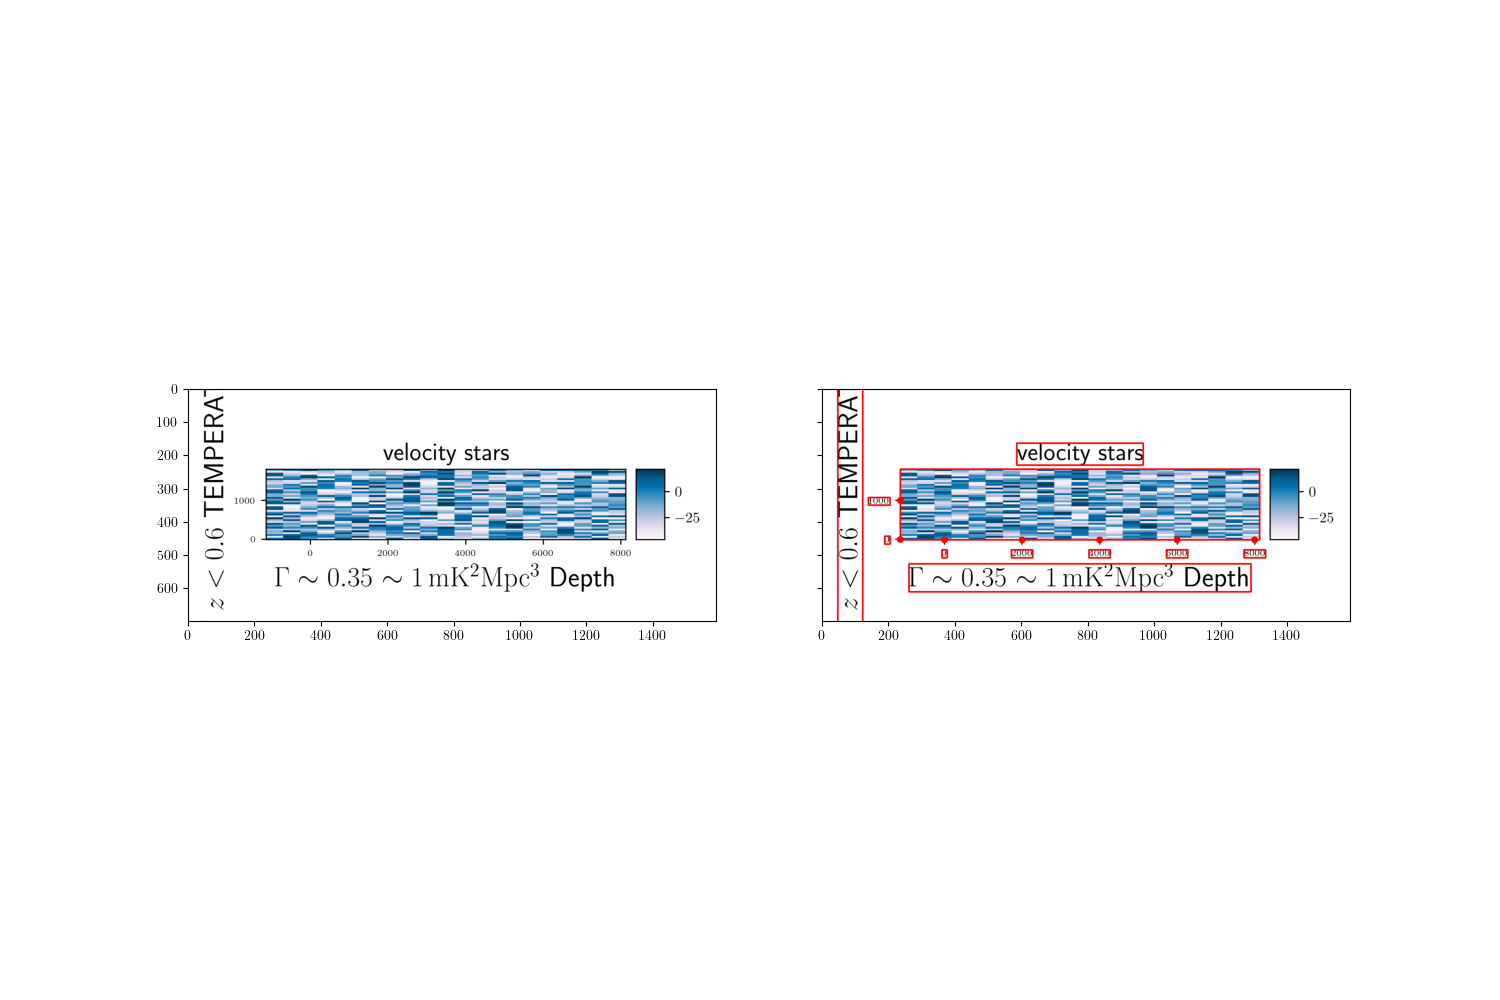

In [511]:
%matplotlib widget
#%matplotlib inline
plt.close('all')

csize = 0

ifig = 0 # which one to plot?

if not save_smalls:
    img = np.array(Image.open(fake_figs_dir+'Picture'+str(ifig+1)+'.png').convert('RGB'))
    datas_plot = datas_all[ifig].copy()
else:
    img = np.array(Image.open(save_small_dir+'Picture'+str(ifig+1)+'.png').convert('RGB'))
    with open(save_small_dir+'Picture'+str(ifig+1)+'.json','r') as f:
        datas_plot1 = json.load(f) # weirdness
        datas_plot = json.loads(datas_plot1)
imgplot = img.copy()


iplot_count = 0
for p,v in datas_plot.items():
    iplot_count += 1
    if 'plot' in p: # not figure stuffs... just yet
        #print('PLOT:', p)
        if v['type'] == 'line':
            xs = v['data pixels']['xs']
            ys = v['data pixels']['ys']
            for xx,yy in zip(xs,ys):
                for x,y in zip(xx,yy):
                    cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
        elif v['type'] == 'scatter':
            xs = v['data pixels']['xs']
            ys = v['data pixels']['ys']
            for x,y in zip(xs,ys):
                cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
            # colormap
            if 'color bar' in v:
                xmin,ymin = int(round(v['color bar']['xmin'])), int(round(img.shape[0]-v['color bar']['ymin']))
                xmax,ymax = int(round(v['color bar']['xmax'])), int(round(img.shape[0]-v['color bar']['ymax']))
                cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
                # colormap ticks
                if 'color bar ticks' in v:
                    for d in v['color bar ticks']:
                        xmin,ymin,xmax,ymax = int(d['xmin']),int(img.shape[0]-d['ymin']),int(d['xmax']),int(img.shape[0]-d['ymax'])
                        # check if we should have it or not
                        if v['color bar']['params']['side'] == 'bottom' or v['color bar']['params']['side'] == 'top':
                            if d['tx']>=v['color bar']['xmin'] and d['tx']<=v['color bar']['xmax']:
                                cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
                                cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
                        else: # side
                            if d['ty']>=v['color bar']['ymin'] and d['ty']<=v['color bar']['ymax']:
                                cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
                                cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
        elif v['type'] == 'histogram':
            # middle of bar
            xs = np.array(v['data pixels']['xs'])
            ys = np.array(v['data pixels']['ys'])
            for x,y in zip(xs,ys): # middle
                cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
            # right
            xsr = np.array(v['data pixels']['xs_right'])
            ysr = np.array(v['data pixels']['ys_right'])
            for x,y in zip(xsr,ysr): # right
                cv.circle(imgplot, (int(x), int(y)), csize, (0,0,255), -1)
            # left
            xsl = np.array(v['data pixels']['xs_left'])
            ysl = np.array(v['data pixels']['ys_left'])
            for x,y in zip(xsl,ysl): # left
                cv.circle(imgplot, (int(x), int(y)), csize, (255,0,125), -1)
        elif v['type'] == 'contour':
            #xs = np.array
            print('no xs/ys yet, faking')
            #xs = []; ys = []
            xs = v['data pixels']['image']['xs']
            ys = v['data pixels']['image']['ys']
            for x,y in zip(xs,ys):
                cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
            
        else:
            print('no idea how to deal!')
            import sys; sys.exit()

        # these are things for every plot
        for d in v['xticks']: # draw x-ticks
            xmin,ymin,xmax,ymax = int(d['xmin']),int(img.shape[0]-d['ymin']),int(d['xmax']),int(img.shape[0]-d['ymax'])
            if d['tx']>=v['square']['xmin'] and d['tx']<=v['square']['xmax']:
                cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
            # also ticks
            if d['tx']>=v['square']['xmin'] and d['tx']<=v['square']['xmax']:
                cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
        for d in v['yticks']: # draw y-ticks
            xmin,ymin,xmax,ymax = int(d['xmin']),int(img.shape[0]-d['ymin']),int(d['xmax']),int(img.shape[0]-d['ymax'])
            if d['ty']>=v['square']['ymin'] and d['ty']<=v['square']['ymax']:
                cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
            if d['ty']>=v['square']['ymin'] and d['ty']<=v['square']['ymax']:
                cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
        if v['type'] == 'line':
            if 'x error bars' in v['data pixels']:
                for il,l in enumerate(v['data pixels']['x error bars']):
                    for ie,(xmin,ymin,xmax,ymax) in enumerate(l):
                        xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                        xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                        # only take parts within square
                        xmin = max(xmin,int(round(v['square']['xmin'])))
                        xmax = min(xmax,int(round(v['square']['xmax'])))
                        ymin = max(ymin,int(round(img.shape[0]-v['square']['ymax'])))
                        ymax = min(ymax,int(round(img.shape[0]-v['square']['ymin'])))
                        cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
            if 'y error bars' in v['data pixels']:
                for l in v['data pixels']['y error bars']:
                    for xmin,ymin,xmax,ymax in l:
                        xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                        xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                        # only take parts within square
                        xmin = max(xmin,int(round(v['square']['xmin'])))
                        xmax = min(xmax,int(round(v['square']['xmax'])))
                        ymin = max(ymin,int(round(img.shape[0]-v['square']['ymax'])))
                        ymax = min(ymax,int(round(img.shape[0]-v['square']['ymin'])))
                        cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
        elif v['type'] == 'scatter' or v['type'] == 'histogram':
            if 'x error bars' in v['data pixels']:
                for xmin,ymin,xmax,ymax in v['data pixels']['x error bars']:
                    xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                    xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                    # only take parts within square
                    xmin = max(xmin,int(round(v['square']['xmin'])))
                    xmax = min(xmax,int(round(v['square']['xmax'])))
                    ymin = max(ymin,int(round(img.shape[0]-v['square']['ymax'])))
                    ymax = min(ymax,int(round(img.shape[0]-v['square']['ymin'])))
                    cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
            if 'y error bars' in v['data pixels']:
                for xmin,ymin,xmax,ymax in v['data pixels']['y error bars']:
                    #print(ymin,ymax)
                    xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                    xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                    xmin = max(xmin,int(round(v['square']['xmin'])))
                    xmax = min(xmax,int(round(v['square']['xmax'])))
                    ymin = max(ymin,int(round(img.shape[0]-v['square']['ymax'])))
                    ymax = min(ymax,int(round(img.shape[0]-v['square']['ymin'])))
                    cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
                    #print('')
        # square
        d = v['square']
        xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
        xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
        cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
        # title bounding box
        if 'title' in v: # has a title?
            d = v['title']
            xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
            xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
            cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
        # xlabel bounding box
        d = v['xlabel']
        xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
        xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
        cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
        # ylabel bounding box
        d = v['ylabel']
        xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
        xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
        cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)

#fig2,ax2 = plt.subplots(1,2,figsize=(20,20), sharex=True, sharey=True) # inline
fig2,ax2 = plt.subplots(1,2,figsize=(15,10), sharex=True, sharey=True) # widget
ax2[0].imshow(img)
ax2[1].imshow(imgplot)
plt.show()

In [501]:
#datas_plot['plot0']['data pixels']

In [508]:
v['data pixels']['image']['ys']

[455.01089157362355,
 449.4553211225653,
 443.89975067150704,
 438.34418022044883,
 432.7886097693906,
 427.2330393183323,
 421.6774688672741,
 416.12189841621586,
 410.56632796515765,
 405.0107575140994,
 399.45518706304114,
 393.89961661198294,
 388.3440461609247,
 382.7884757098665,
 377.2329052588082,
 371.67733480774996,
 366.12176435669176,
 360.5661939056335,
 355.01062345457524,
 349.45505300351704,
 343.8994825524588,
 338.3439121014005,
 332.7883416503423,
 327.23277119928406,
 321.6772007482258,
 316.1216302971676,
 310.56605984610934,
 305.0104893950511,
 299.4549189439929,
 293.8993484929347,
 288.34377804187636,
 282.78820759081816,
 277.23263713975996,
 271.6770666887017,
 266.12149623764344,
 260.56592578658524,
 255.01035533552698,
 249.45478488446872,
 243.89921443341052,
 455.01089157362355,
 449.4553211225653,
 443.89975067150704,
 438.34418022044883,
 432.7886097693906,
 427.2330393183323,
 421.6774688672741,
 416.12189841621586,
 410.56632796515765,
 405.010757514

In [31]:
ifig = 7 # which one to plot?

if not save_smalls:
    img = np.array(Image.open(fake_figs_dir+'Picture'+str(ifig+1)+'.png').convert('RGB'))
    datas_plot = datas_all[ifig].copy()
else:
    img = np.array(Image.open(save_small_dir+'Picture'+str(ifig+1)+'.png').convert('RGB'))
    with open(save_small_dir+'Picture'+str(ifig+1)+'.json','r') as f:
        datas_plot1 = json.load(f) # weirdness
        datas_plot = json.loads(datas_plot1)

In [32]:
datas_plot['plot0'].keys()

dict_keys(['type', 'data', 'data pixels', 'data from plot', 'xticks', 'yticks', 'square', 'xlabel', 'ylabel'])

In [33]:
datas_plot['plot0']['data from plot']

{'data': ['non serializable entry',
  'non serializable entry',
  'non serializable entry'],
 'plot params': {'linethick': [2.614879465821844,
   1.4730744887847127,
   1.1188482698177826],
  'linestyles': [[0, [3, 10, 1, 10]], 'solid', 'dotted'],
  'markers': ['3', 'P', '+'],
  'marker size': [1, 1, 1]},
 'y error bars': [['non serializable entry'],
  ['non serializable entry'],
  ['non serializable entry']]}